In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re

# Read in Data

In [7]:
data_dir = r'../data/'

data = pd.DataFrame()

for entry in os.scandir(data_dir):
    if (entry.path.endswith('.json') and entry.is_file()):
        if data.empty:
            data = pd.read_json(entry.path)
        else:
            entry_data = pd.read_json(entry.path)
            data = pd.concat([data, entry_data], ignore_index=True)

# Data Clean-up

In [8]:
# For all of these, see explanations below.

# Remove duplicates
data.drop_duplicates(subset ="post_id", 
                     keep = "last", inplace = True)

# Things deemed not important:
# fuel, VIN, drive, size, type
data.drop(['cylinders', 'VIN', 'drive', 'size', 'type', 'fuel','paint color','condition'],
          axis=1, inplace=True)
# Remove listings that have a null "brand". Reason: It is ~5% missing, and brand is important to 
# categorize
data = data[data['brand'].notna()]
# Remove salvage vehicles.
# data = data[data['condition'] != 'salvage']

# Change odometer inputs to thousands
data['odometer'] = np.where((data['odometer'] < 1000.0) & (data['year'] < 2018),
                           data['odometer'] * 1000,
                           data['odometer'])

# !! TO CHANGE:
# Remove values with odometer = 0 below the year 2018
# CHANGE IT TO NA INSTEAD OF 0 OR FALSE. Deal with null values of odometer
data.drop(data[data['odometer'] == False][data['year'] <= 2018].index, inplace=True)

# Remove edge case where a certain salesman sets odometer to "1"
data.drop(data[data['odometer'] == 1].index, inplace=True)

# Remove entries with no model data
data.drop(data[data['model'] == ''].index, inplace=True)


data.shape

C:\Users\justi\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(5586, 9)

### Why did I drop ['cylinders', 'VIN', 'drive', 'size', 'type', 'fuel', 'condition', 'paint color']?

In [9]:
# Things deemed not important:
# cylinders, fuel, VIN, drive, size, type, fuel
# These categories generally stay the same within the same model.
# Rarely will you see different values within the same model, but when you do,
# there is but a small change in price. We want to focus on the most important
# factors, rather than the miniscule.
# VIN is unique to every vehicle.

# To add onto that, see the data below of missing values.
# Above 25% missing: Cylinders, VIN, drive, size, type, paint color
# For cylinders, VIN, drive, size and type, we will remove the columns as a whole. These aren't important
# in the grand scheme of things, because when a vehicle is searched, it's assumed these are constant for that model 
# (except VIN).

# Paint color: There is very very little affect on price based on paint color.
# Considering paint having an issue of 33% missing, this poses a problem.
# The column will be removed.

# Condition: Condition is subjective.
# Unless salvaged, which I assume will be marked, there is very little difference.

# Check NA (percentage missing):
data.isnull().sum() *100 / len(data)

post_id          0.000000
brand            0.000000
url              0.000000
price            0.000000
year             0.000000
model            0.000000
odometer        19.584676
title status     0.000000
transmission     0.000000
dtype: float64

In [10]:
# Problems to deal with:

#-----------------------------------------------

# What should we do about the rest of our missing data?
# Well, if we drop all na, then we are left with about only half of the data. 
# That won't be good.
# data.dropna().shape

#-----------------------------------------------

# people love to put the odometer, in kms, instead of a full amount. (eg if it's at 150,000 kms, they just put 150)

# data[data['odometer'] == 200.0]
# you can see that these vehicles are all older, and are definitely not only 200 kms driven.
# 200,000 sounds about right.

# data['odometer'] = np.where((data['odometer'] < 1000.0) & (data['year'] < 2018),
#                            data['odometer'] * 1000,
#                            data['odometer'])

# If you run a quick "data[data['odometer'] < 1000]", everything looks about right.

#-----------------------------------------------

# Remove all vehicles with odometer = 0 and year <= 2018.

# data.drop(data[data['odometer'] == False][data['year'] <= 2018].index, inplace=True)

# Odometer is a critical part in deciding the price of a vehicle.
# In data size, we aren't missing out on much if we just remove these entries.
# As I am writing this, out of 2598 entries, only 1 satisfies this.

#-----------------------------------------------

# There's a specific bmw salesman who likes to post ads with an odometer of 1, regardless of actual odometer.
# This really messes with the data.
# Let's remove their entries. They're not that many.
# Ads with a "1" odometer don't really mean it has 1 km on it, either.

# data.drop(data[data['odometer'] == 1].index, inplace=True)

#-----------------------------------------------

# There's a decent amount of data that has model = "". We need to get rid of those, as they
# won't be useful in determining model price if there is no model.

# data.drop(data[data['model'] == ''].index, inplace=True)

data.shape

#-----------------------------------------------

# same model?
# if "civic" in model.split():
# model = "civic"

(5586, 9)

In [11]:
# How are we going to use "model" consistently? Do we mix all "civic" together? (eg civic sport, civic coupe, civic touring..)
# Answer: YES.

# How do we solve it?
# If model contains "civic" -> make it "civic"
# If model has any of the brands below, remove it.
brands = ["ford", "toyota", "chevrolet", "chev", "chevy", "honda", "jeep", "hyundai", "subaru", 
          "kia", "gmc", "ram", "dodge", "mercedes-benz", "mercedes", "mercedesbenz", "volkswagen",
          "vw", "bmw", "saturn", "land rover", "landrover", "pontiac", "mitsubishi", "lincoln",
          "volvo", "mercury", "harley-davidson", "harley", "rover", "buick", "cadillac", "infiniti",
          "infinity", "audi", "mazda", "chrysler", "acura", "lexus", "nissan", "datsun", "jaguar",
          "alfa", "alfa-romeo", "aston", "aston-martin", "ferrari", "fiat", "hennessey", "porche",
          "noble", "morgan", "mini", "tesla", "porsche", "hummer", "scion", "smart", "suzuki",
          "isuzu", "mclaren", "bentley", "rolls-royce", "mercedesbenz", "maserati"]

# v_title.remove(word)

# Known vehicles that have a consistent price among trims:
# f150 -> f-150
# contains f150 or f-150 -> f-150
# crv -> cr-v
# f350 -> f-350
# contains f350 or f-350
# ram 1500 -> 1500
# is 250 -> is250


# Remove word from model
remove_words = ['convertible', 'benz']
data["model"] = [' '.join([word for word in x.split() if word not in remove_words]) for x in data["model"]]

# Replace with base model name
contains_words = ['civic', 'accord', 'corolla', 'elantra', 'miata', 'rav4', 'odyssey', 'fusion']

for word in contains_words: 
    if word == 'civic':
        # Replaces all civics that aren't si or sir
        data.loc[data.model.str.contains(word) & ~data.model.str.contains('si') & ~data.model.str.contains('sir'), 'model'] = word
        # Replaces all sir with 'civic sir'
        data.loc[data.model.str.contains(word) & data.model.str.contains(pat='\\bsir\\b', regex=True), 'model'] = 'civic sir'
        # Replaces all si with 'civic si'
        data.loc[data.model.str.contains(word) & data.model.str.contains(pat='\\bsi\\b', regex=True), 'model'] = 'civic si'
        
    
    else:
        data.loc[data.model.str.contains(word), 'model'] = word

# civic si, civic sir
#
data[data['odometer'].isnull()]
data.drop(data[data['model'] == ''].index, inplace=True)
dict(data['model'].value_counts())


{'civic': 232,
 'corolla': 123,
 'accord': 101,
 '3': 72,
 'jetta': 61,
 'mustang': 55,
 'rav4': 52,
 'f-150': 47,
 'grand caravan': 45,
 'x5': 41,
 'odyssey': 38,
 'camry': 37,
 'cr-v': 31,
 'elantra': 31,
 'rogue': 31,
 'escape': 30,
 'mdx': 27,
 'golf': 27,
 'fusion': 27,
 'outlander': 26,
 'forester': 25,
 'altima': 24,
 '1500': 24,
 'journey': 24,
 'sienna': 23,
 'yaris': 22,
 'tacoma': 22,
 'passat': 22,
 'sentra': 22,
 'tiguan': 21,
 'accent': 21,
 'grand cherokee': 20,
 'focus': 20,
 'corvette': 19,
 'cx-5': 19,
 'x3': 19,
 'q5': 19,
 'prius': 18,
 'cruze': 17,
 'pathfinder': 17,
 'land range sport': 16,
 'fit': 16,
 '5': 16,
 'c-class': 16,
 'outback': 16,
 'a4': 15,
 'c300': 15,
 'wrangler': 15,
 'soul': 15,
 'pilot': 15,
 'matrix': 15,
 'caravan': 15,
 'tl': 15,
 'f150': 15,
 'camaro': 15,
 'civic si': 15,
 'f-350': 15,
 'camry le': 14,
 '323i': 14,
 'crv': 14,
 'mazda3': 14,
 'e350': 14,
 'explorer': 13,
 'santa fe': 13,
 'ranger': 13,
 'g35': 13,
 'silverado 1500': 13,
 'r

In [12]:
# data['odometer'] = np.where((data['odometer'] < 1000.0) & (data['year'] < 2018),
#                            data['odometer'] * 1000,
#                            data['odometer'])


# Plot and Visualize

Text(0.5, 0, 'count')

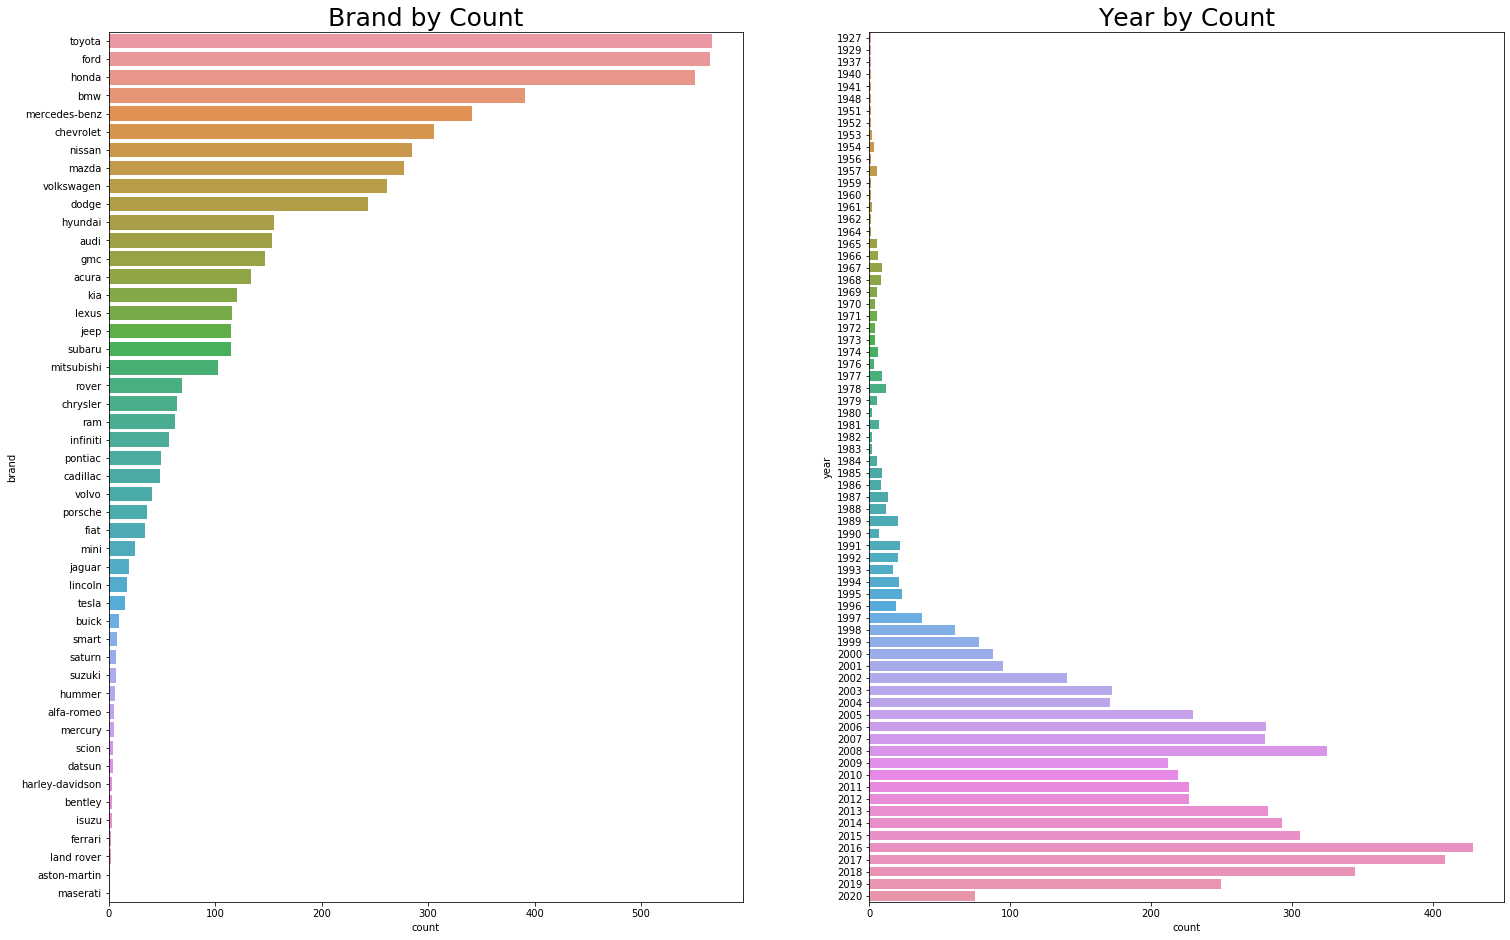

In [13]:
fig, axes = plt.subplots(1,2,figsize=(25,16))

(sns.barplot(y=data.brand.value_counts().index, x=data.brand.value_counts(), orient='h',ax=axes[0])
 .set_title('Brand by Count',fontsize=25))
axes[0].set_ylabel('brand')
axes[0].set_xlabel('count')
(sns.barplot(y=data.year.value_counts().index, x=data.year.value_counts(), orient='h',ax=axes[1])
 .set_title('Year by Count',fontsize=25))
axes[1].set_ylabel('year')
axes[1].set_xlabel('count')

Text(0, 0.5, '')

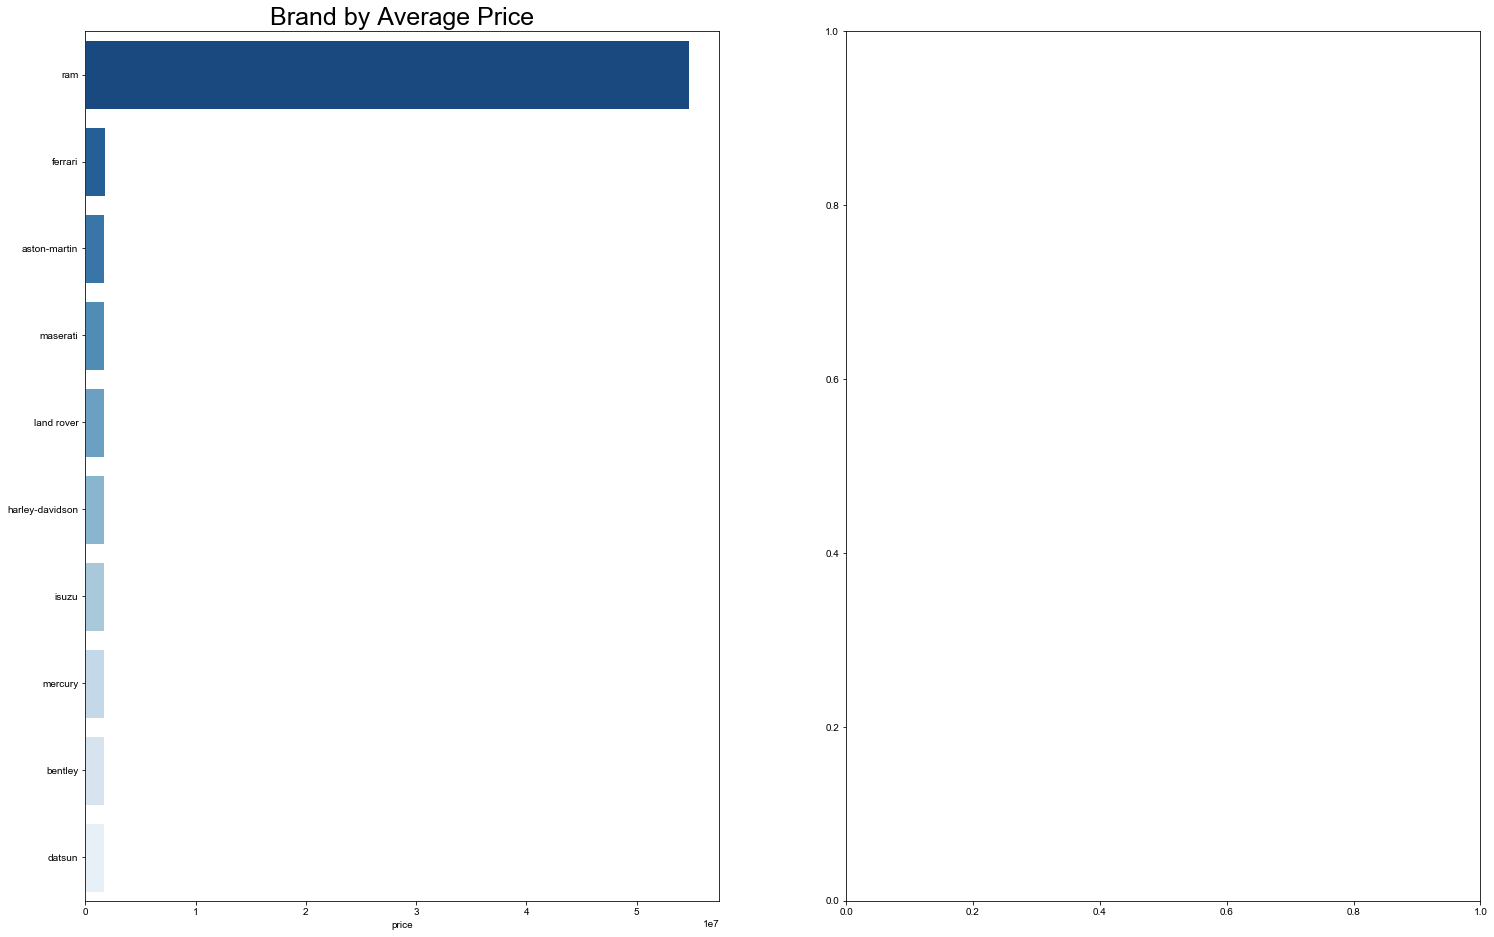

In [14]:
def bayes_avg(df,cond,col):
    """
    This function was taken from Heidi Jiang's "New Porkers" project
    See: https://github.com/heidijiang/new-porkers/
    
    """
    v = df.groupby(cond)[col].size()
    m = df[cond].value_counts().mean()
    w = v/(v+m)
    S = w*df.groupby(cond)[col].mean() + (1-w)*df[col].mean()
    return S

pr = (bayes_avg(data.dropna(how='any'), 'brand', 'price').sort_values(ascending=False)
     .reset_index().sort_values('price', ascending=False))
pr = pr.iloc[:10]

pr

fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette(sns.cubehelix_palette(8))

sns.set(font_scale = 1.5)

sns.barplot(data=pr,x='price',y='brand',orient='h',ax=axes[0], palette="Blues_r").set_title('Brand by Average Price', fontsize=25)
axes[0].set_ylabel('')